# Import Important Libraries

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

In [2]:
DATA_PATH = '../data'

# Import Raw Data

In [3]:
data = pd.read_parquet(f'{DATA_PATH}/raw/Transacation_inflows_with_date_3k.pqt')
data.head()

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category
0,0,acc_0,METROPOLITAN REG PAYROLL PPD ID: XXXXXXXXXX,2477.02,2022-03-18,PAYCHECK
1,0,acc_0,METROPOLITAN REG VENDOR XXXXXX CCD ID: XXXXXXXXXX,100.00,2022-10-25,EXTERNAL_TRANSFER
2,0,acc_0,ONSTAR SERVICES 888-4ONSTAR MI 08/25,6.29,2022-08-26,MISCELLANEOUS
3,0,acc_0,Zelle payment from CHRISTOPHER J LYONS XXXXXXX...,277.00,2022-06-03,EXTERNAL_TRANSFER
4,0,acc_0,METROPOLITAN REG VENDOR XXXXXX CCD ID: XXXXXXXXXX,100.00,2022-07-29,EXTERNAL_TRANSFER


In [4]:
data['posted_date'] = pd.to_datetime(data['posted_date'])
data['year'] = pd.DatetimeIndex(data['posted_date']).year
data['month'] = pd.DatetimeIndex(data['posted_date']).month
data['day'] = pd.DatetimeIndex(data['posted_date']).day
data.head()

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category,year,month,day
0,0,acc_0,METROPOLITAN REG PAYROLL PPD ID: XXXXXXXXXX,2477.02,2022-03-18,PAYCHECK,2022,3,18
1,0,acc_0,METROPOLITAN REG VENDOR XXXXXX CCD ID: XXXXXXXXXX,100.00,2022-10-25,EXTERNAL_TRANSFER,2022,10,25
2,0,acc_0,ONSTAR SERVICES 888-4ONSTAR MI 08/25,6.29,2022-08-26,MISCELLANEOUS,2022,8,26
3,0,acc_0,Zelle payment from CHRISTOPHER J LYONS XXXXXXX...,277.00,2022-06-03,EXTERNAL_TRANSFER,2022,6,3
4,0,acc_0,METROPOLITAN REG VENDOR XXXXXX CCD ID: XXXXXXXXXX,100.00,2022-07-29,EXTERNAL_TRANSFER,2022,7,29


In [5]:
data['category'].unique()

array(['PAYCHECK', 'EXTERNAL_TRANSFER', 'MISCELLANEOUS',
       'INVESTMENT_INCOME', 'TAX', 'DEPOSIT', 'SELF_TRANSFER', 'REFUND',
       'PAYCHECK_PLACEHOLDER', 'INSURANCE', 'OTHER_BENEFITS',
       'UNEMPLOYMENT_BENEFITS', 'LOAN', 'SMALL_DOLLAR_ADVANCE'],
      dtype=object)

In [6]:
consumer_stats = (
    data[['prism_consumer_id', 'amount', 'category']]
    .groupby('prism_consumer_id').describe()
)
consumer_stats.columns = consumer_stats.columns.droplevel(0)
consumer_stats.head()

,count,mean,std,min,25%,50%,75%,max
prism_consumer_id,,,,,,,,
0,91.0,1212.224505,3938.620347,0.04,75.0000,100.00,2331.710,37000.00
2,113.0,3094.150708,18144.509122,19.00,300.0000,500.00,1000.000,184162.23
4,152.0,3043.144079,3526.443713,0.05,360.2275,1123.87,5485.290,19000.00
7,129.0,1939.644109,3063.197693,0.28,7.4500,300.00,4086.450,16000.00
9,375.0,574.245360,1139.614461,0.01,21.6100,100.00,705.065,13000.00


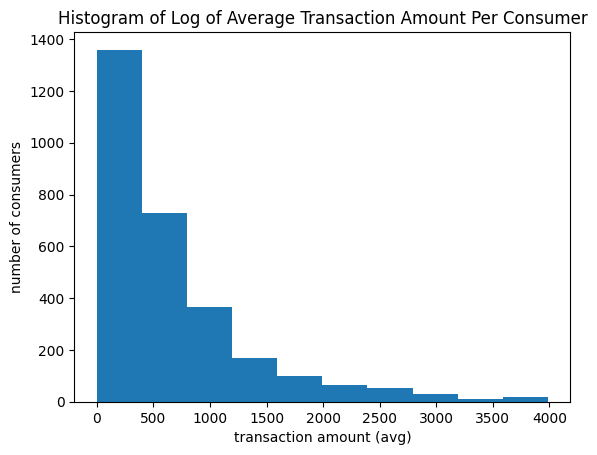

In [17]:
plt.hist(
    (consumer_stats['mean'][consumer_stats['mean'] < 4000])
);
plt.xlabel('transaction amount (avg)')
plt.ylabel('number of consumers')
plt.title('Histogram of Log of Average Transaction Amount Per Consumer');

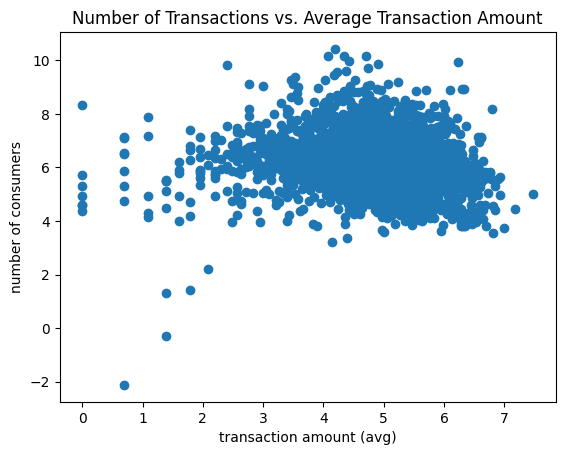

In [19]:
plt.scatter(
    x = np.log(consumer_stats['count']),
    y = np.log(consumer_stats['mean']),
);
plt.xlabel('transaction amount (avg)')
plt.ylabel('number of consumers')
plt.title('Number of Transactions vs. Average Transaction Amount');

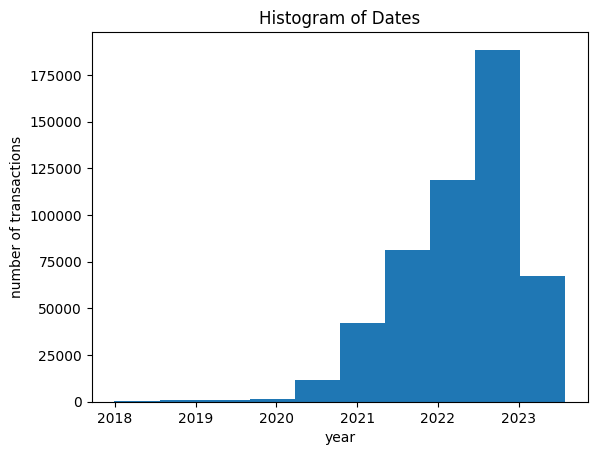

In [32]:
plt.hist(pd.to_datetime(data['posted_date']))
plt.xlabel('year')
plt.ylabel('number of transactions')
plt.title('Histogram of Dates');

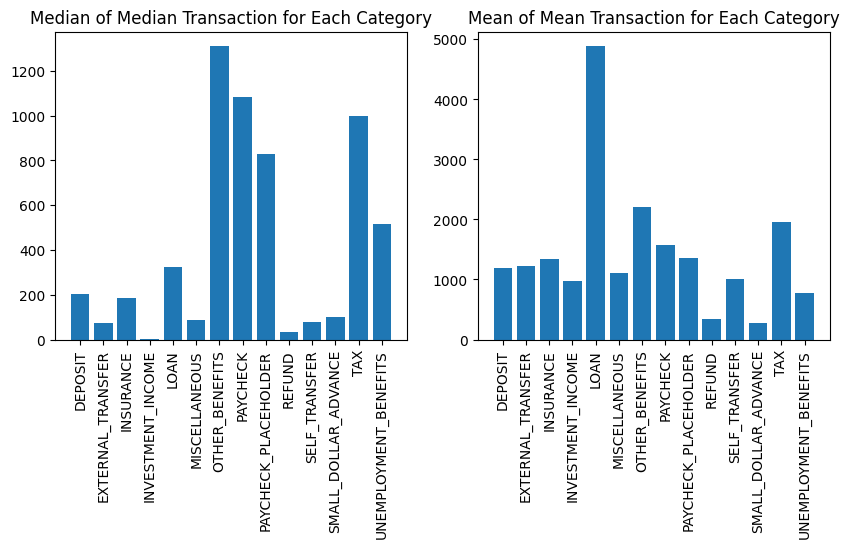

In [10]:
cat_per_cons_median = (
    data[['prism_consumer_id', 'amount', 'category']]
    .groupby(['prism_consumer_id', 'category']).median()
    .groupby('category').median()
)
cat_per_cons_mean = (
    data[['prism_consumer_id', 'amount', 'category']]
    .groupby(['prism_consumer_id', 'category']).mean()
    .groupby('category').mean()
)


fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].bar(
    cat_per_cons_median.index,
    cat_per_cons_median['amount'],
)
ax[0].set_xticks(
    cat_per_cons_median.index,
    labels = cat_per_cons_median.index, 
    rotation = 90
)
ax[0].title.set_text('Median of Median Transaction for Each Category')
ax[1].bar(
    cat_per_cons_mean.index,
    cat_per_cons_mean['amount'],
)
ax[1].set_xticks(
    cat_per_cons_mean.index,
    labels = cat_per_cons_mean.index, 
    rotation = 90
);
ax[1].title.set_text('Mean of Mean Transaction for Each Category');

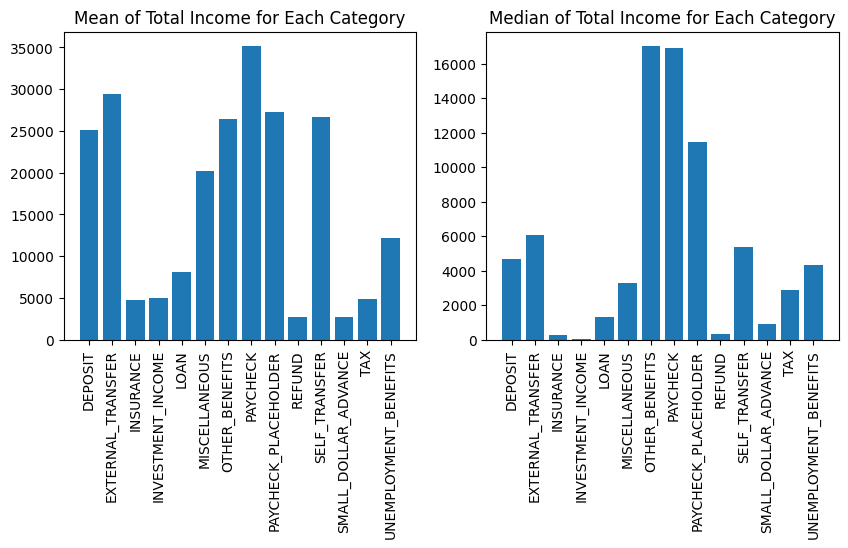

In [11]:
cat_per_cons_total_mean = (
    data[['prism_consumer_id', 'amount', 'category']]
    .groupby(['prism_consumer_id', 'category']).sum()
    .groupby('category').mean()
)

cat_per_cons_total_median = (
    data[['prism_consumer_id', 'amount', 'category']]
    .groupby(['prism_consumer_id', 'category']).sum()
    .groupby('category').median()
)


fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].bar(
    cat_per_cons_total_mean.index,
    cat_per_cons_total_mean['amount'],
)
ax[0].set_xticks(
    cat_per_cons_total_mean.index,
    labels = cat_per_cons_total_mean.index, 
    rotation = 90
)
ax[0].title.set_text('Mean of Total Income for Each Category')
ax[1].bar(
    cat_per_cons_total_median.index,
    cat_per_cons_total_median['amount'],
)
ax[1].set_xticks(
    cat_per_cons_total_median.index,
    labels = cat_per_cons_total_median.index, 
    rotation = 90
);
ax[1].title.set_text('Median of Total Income for Each Category');

In [12]:
consumer_stats_2022 = (
    data[data['year'] == 2022]
    [['prism_consumer_id', 'year', 'amount', 'category']]
    .groupby(['prism_consumer_id', 'year']).describe()
)
consumer_stats_2022.columns = consumer_stats_2022.columns.droplevel(0)
consumer_stats_2022.head()

,,count,mean,std,min,25%,50%,75%,max
prism_consumer_id,year,,,,,,,,
0,2022,84.0,1206.902381,4087.641402,0.04,75.000,100.00,2331.71,37000.00
4,2022,138.0,3162.638913,3586.309711,0.05,366.435,1253.06,5485.29,19000.00
7,2022,92.0,1954.015543,3063.186312,0.28,7.035,300.00,4124.98,12854.25
11,2022,33.0,489.247879,874.632883,0.01,5.000,65.04,575.00,4194.51
13,2022,139.0,529.479856,1333.647162,0.01,0.545,1.27,115.71,8474.00


In [13]:
consumer_stats_2022['count'].mean(), consumer_stats_2022['count'].median()

(108.61208875286917, 81.0)

In [15]:
consumer_stats.mean()

count      172.533625
mean       876.850606
std       1920.075352
min          5.541429
25%         94.280123
50%        352.673761
75%        964.668826
max      15863.761631
dtype: float64